# Titanic Kaggle Challenge

In [ ]:
# Import general libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
!pip install -Uq seaborn
import seaborn as sns

# Import scikit-learn libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

# Import keras libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Import Data
Check if the training data exists and if not download it directly from Kaggle.

In [145]:
# This code block downloads the data from kaggle
# to the local runtime filesystem when running on
# Google Colab.
def find_platform():
  try:
    import google.colab
    return True
  except:
    return False

def download_data_colab(file_path, expected_file_size):
  print('Importing training data from Kaggle')
  # Install kaggle CLI
  ! pip install -q kaggle

  # Check if Kaggle API key exists
  api_key_path = '/root/.kaggle/kaggle.json'
  if not os.path.exists(api_key_path):
    # Upload Kaggle API key
    print('Upload kaggle.json with API keys')
    print('To get a new kaggle.json file, login to kaggle.com, go to Settings -> Account -> API -> Create New Token.\n')
    from google.colab import files
    files.upload()

    # Set permissions
    ! mkdir ~/.kaggle
    ! mv kaggle.json ~/.kaggle
    ! chmod 600 ~/.kaggle/kaggle.json

  # Download data then unzip then remove download
  ! kaggle competitions download -c titanic
  ! unzip -o titanic.zip
  ! rm titanic.zip

  # Confirm the training data now exists
  if not os.path.exists(file_path):
    raise FileNotFoundError(f"The training data '{file_path}' did not download")
  else:
    file_size = os.path.getsize(file_path)
    if file_size != expected_file_size:
      raise ValueError(f'Training data "{file_path}" has an unexpected size. Expected size: {expected_file_size} bytes. Actual size: {file_size} bytes.')
    else:
      print(f'Training data "{file_path}" download OK')

In [146]:
file_path = '/content/train.csv'  # Google Colab path
expected_file_size = 61194    # train csv file size

# Check if the code is running in Google Colab
if find_platform():
  print('Running in Google Colab')
  # If training data does not exist then download it
  if not os.path.exists(file_path):
      download_data_colab(file_path=file_path, expected_file_size=expected_file_size)

  # If training data is the wrong size re-download it
  elif os.path.getsize(file_path) != expected_file_size:
      download_data_colab(file_path=file_path, expected_file_size=expected_file_size)

  # If training data looks good then move on
  else:
      print('Training data already exists ')

else:
  print('Not running in Google Colab')

Running in Google Colab
Training data already exists 


# Examine the Data
It is important to examine the data and become familiar with the domain.

In [147]:
# Load data into pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [148]:
# Format column name in lower case
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [149]:
# Calculate percentage of nans
def missing_data(df):
  nans = pd.DataFrame({'nans': df.isnull().sum()})
  nans['percent'] = (nans['nans'] / len(df) * 100)
  nans = nans[nans.percent > 0]
  print(nans)

missing_data(train)
missing_data(test)

          nans    percent
age        177  19.865320
cabin      687  77.104377
embarked     2   0.224467
       nans    percent
age      86  20.574163
fare      1   0.239234
cabin   327  78.229665


The percentage of nans in each column of train and test is comparable. I will temporarily combine train and test get larger a sample size while I deal with missing values.

In [150]:
# Combine data
train['train'] = 1  # Set a flag for seperating out train and test later
test['train'] = 0
data = pd.concat([train, test])

In [151]:
data.survived.mean()

0.3838383838383838

Only 38% of passengers survived.

In [152]:
data.describe(include=['O'])

,name,sex,ticket,cabin,embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


There are two passengers named Miss Kate Connolly, but these look like different people.


In [153]:
data.loc[data.name == 'Connolly, Miss. Kate']

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
289,290,1.0,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q,1
6,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0


Both Kate Connollys are travelling without family members. Was it common for women to be travelling on the titanic alone?

In [154]:
print(f'Number of passengers: {len(data)}')
data.loc[(data.sex == 'female') & (data.parch == 0) & (data.sibsp == 0) & (data.age >= 18)].describe()

Number of passengers: 1309


,passengerid,survived,pclass,age,sibsp,parch,fare,train
count,137.000000,89.000000,137.000000,137.000000,137.0,137.0,137.000000,137.000000
mean,666.861314,0.786517,2.051095,31.375912,0.0,0.0,46.727101,0.649635
std,374.725197,0.412088,0.860243,10.888604,0.0,0.0,73.081207,0.478835
min,3.000000,0.000000,1.000000,18.000000,0.0,0.0,6.750000,0.000000
25%,328.000000,1.000000,1.000000,23.000000,0.0,0.0,7.925000,0.000000
50%,707.000000,1.000000,2.000000,30.000000,0.0,0.0,13.000000,1.000000
75%,978.000000,1.000000,3.000000,36.000000,0.0,0.0,49.504200,1.000000
max,1306.000000,1.000000,3.000000,63.000000,0.0,0.0,512.329200,1.000000


Out of 1,309 total passengers, there were 137 women aged 18+ travelling without stated family members (approx 10% of all passengers). At least 25% of those were travelling first class and at least 50% first or second class. 79% survived.

## Family Groups
### Anna Ward
One of the female passengers travelling alone has the most expensive fare (£512).

In [155]:
data.loc[(data.fare > 512)]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
258,259,1.0,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,1
679,680,1.0,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,1
737,738,1.0,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,1
343,1235,NaN,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,0


An Internet search on "Anna Ward" shows that she was the personal maid to wealthy widow Charlotte Drake Cardeza. A group of four passengers all travelled on the same ticket, "PC 17755". Anna, Charlotte, Thomas (Charlotte's son) and Gustave Lesurer (Thomas' manservant).

It is not clear from the data whether the fare was paid per passenger or for the entire group. It looks like Charlotte and Thomas had a suite of cabins (B51, B53 and B55), Gustave had cabin B101 there are no data on the cabin Anna used.

This highlights some challenges with the data. The fare associated with Anna is skewing the average fare paid by women travelling alone (is it even true to say that Anna was travelling alone?). Perhaps there were other passengers travelling in groups that do not have a parent/child or sibling/spouce relationship recorded in the data.

All four members of the Cardeza party escaped on lifeboat number 3 and survived.

### Contrasting Travelling Parties
Exploring further the nature of cabin sharing shows contrasting travel arrangements. The cabins shared by the most occupants are "C23 C25 C27", with six occupants and G6 and "B57 B59 B63 B66", with five.

In [156]:
data.cabin.value_counts().head()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
Name: cabin, dtype: int64

In [157]:
data.loc[(data.cabin == 'C23 C25 C27')]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
27,28,0.0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S,1
88,89,1.0,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0,C23 C25 C27,S,1
341,342,1.0,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0,C23 C25 C27,S,1
438,439,0.0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0,C23 C25 C27,S,1
53,945,NaN,1,"Fortune, Miss. Ethel Flora",female,28.0,3,2,19950,263.0,C23 C25 C27,S,0
69,961,NaN,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60.0,1,4,19950,263.0,C23 C25 C27,S,0


In [158]:
data.loc[(data.cabin == 'B57 B59 B63 B66')]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
311,312,1.0,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,1
742,743,1.0,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,1
24,916,NaN,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.375,B57 B59 B63 B66,C,0
64,956,NaN,1,"Ryerson, Master. John Borie",male,13.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C,0
142,1034,NaN,1,"Ryerson, Mr. Arthur Larned",male,61.0,1,3,PC 17608,262.375,B57 B59 B63 B66,C,0


In [159]:
data.loc[(data.cabin == 'G6')]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
10,11,1.0,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,1
205,206,0.0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S,1
251,252,0.0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S,1
394,395,1.0,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S,1
117,1009,NaN,3,"Sandstrom, Miss. Beatrice Irene",female,1.0,1,1,PP 9549,16.7000,G6,S,0


Cabin "C23 C25 C27" looks like a suite of rooms in first class, accomodating the "Fortune" family of two elder parents and four adult children.

Similarly cabin "B57 B59 B63 B66" looks like a suite of rooms in first class, accomodating the "Ryerson" family of two parents and three children (aged 21, 18 and 13).

Contrastingly, cabin "G6" looks like a single room in third class with two young women (aged 29 1nd 24), who are possibly related with very similar surnames, and three infant children aged under 5. Mrs Sandstrom and her oldest daughter survived (her youngest daughter is in the test data so we do not know if she survived) but Mrs Strom and her child did not.

It might be that ticket, combined with young age and travelling with a parent, could indicate the same fate as an adult on the same ticket.

In [160]:
# Group passengers travelling on the same ticket
ticket_groups = data[data.pclass==3].groupby(['ticket', 'fare'])['fare']
ticket_groups = ticket_groups.size().reset_index(name='num_passengers')
ticket_groups['fare_per_passenger'] = ticket_groups.fare / ticket_groups.num_passengers

# Ticket with the most passengers
ticket_groups.sort_values(by='num_passengers', ascending=False).head(1)

,ticket,fare,num_passengers,fare_per_passenger
488,CA. 2343,69.55,11,6.322727


In [161]:
# View the passengers on the ticket
data[data.ticket == 'CA. 2343']

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
159,160,0.0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,1
180,181,0.0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,1
201,202,0.0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,1
324,325,0.0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,1
792,793,0.0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,1
846,847,0.0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,1
863,864,0.0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,1
188,1080,NaN,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
342,1234,NaN,3,"Sage, Mr. John George",male,NaN,1,9,CA. 2343,69.55,NaN,S,0
360,1252,NaN,3,"Sage, Master. William Henry",male,14.5,8,2,CA. 2343,69.55,NaN,S,0


There are 11 passengers on ticket CA. 2343. The Sage family has two parents and nine children travelling together on the same ticket. At least seven of the children did not survive and we don't have survival data in the training set for the parents or the remaining children.  

## Fare
Assess if the fare is per person or a group fare for passengers travelling together (for example on the same ticket). First, determine if all passengers on the same ticket paid the same fare.

In [162]:
# Group by ticket then check if fares are the same within each group
same_fare_tickets = data.groupby('ticket')['fare'].nunique()
same_fare_tickets[same_fare_tickets > 1]

ticket
7534    2
Name: fare, dtype: int64

Only two passengers travelling on the same ticket paid a different fare. These fares are close in value.

In [163]:
data[data.ticket == '7534']

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
138,139,0.0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S,1
876,877,0.0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S,1


Focussing on third class, is there a relationship between number of passengers per ticket and fare?

In [164]:
# Group passengers by ticket
df = data[data.pclass==3].groupby(['ticket', 'fare'])['fare'].size()
df = df.reset_index(name='num_passengers')
df['fare_per_passenger'] = df.fare / df.num_passengers

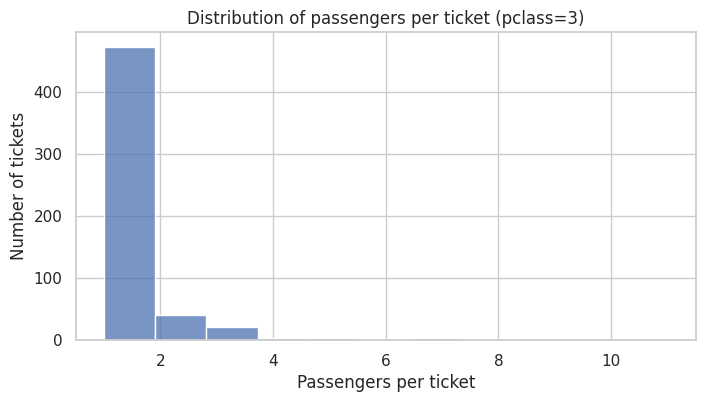

In [165]:
# Plot passengers per ticket
sns.set(style='whitegrid')
plt.figure(figsize=(8, 4))
sns.histplot(x='num_passengers', label='ticket', data=df)
plt.title('Distribution of passengers per ticket (pclass=3)')
plt.xlabel('Passengers per ticket')
plt.ylabel('Number of tickets')
plt.show()

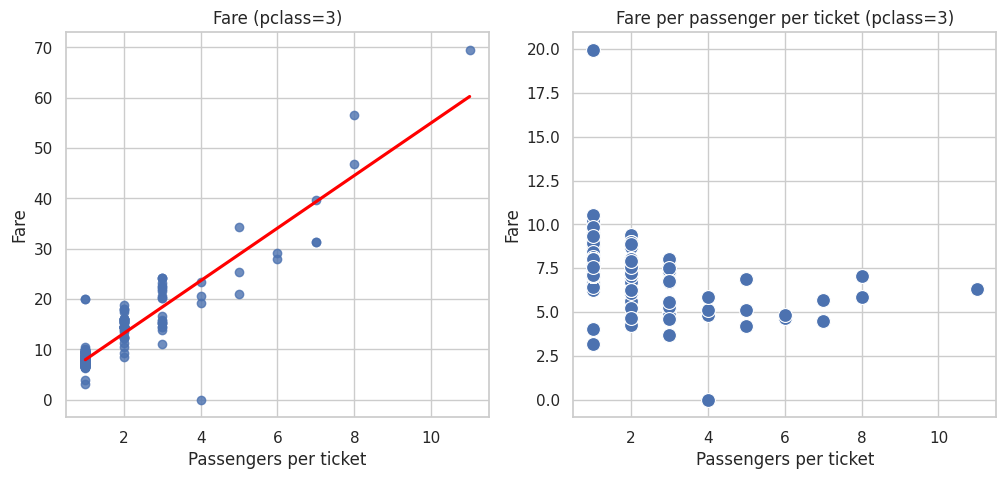

In [166]:
# Plot fare against number of passengers on each ticket
sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot fare versus passengers per ticket
sns.regplot(x='num_passengers', y='fare', data=df, scatter=True, ci=None, line_kws={"color": "red"}, ax=axes[0])
axes[0].set_title('Fare (pclass=3)')
axes[0].set_xlabel('Passengers per ticket')
axes[0].set_ylabel('Fare')

# Plot fare per passenger vs passengers per ticket
sns.scatterplot(x='num_passengers', y='fare_per_passenger', data=df, marker='o', s=100, ax=axes[1])
axes[1].set_title('Fare per passenger per ticket (pclass=3)')
axes[1].set_xlabel('Passengers per ticket')
axes[1].set_ylabel('Fare per passenger')
plt.show()

There looks like a clear linear correlation between fare and the number of passengers per ticket. That implies the fare is for all passengers on the ticket and not the fare for the individual.

There are two outliers with a fare per passenger per ticket of nearly £20. This looks like two brothers called Hagland travelling together, so perhaps the ticketing had a glitch for these passengers. There are also four passengers with a fare = 0, which look like employees (the ticket value is 'LINE').

In [167]:
# Exclude the Haglands as outliers
no_outliers = df[(df.fare_per_passenger < 19)]

fare_stds = (no_outliers.fare.max() - no_outliers.fare.mean()) / no_outliers.fare.std()
print(f'Fare:\t\t\tmax value is {fare_stds:.1f} standard deviations from mean')


fare_per_pass_stds = (no_outliers.fare_per_passenger.max() - no_outliers.fare_per_passenger.mean()) / no_outliers.fare_per_passenger.std()
print(f'Fare per passenger:\tmax value is {fare_per_pass_stds:.1f} standard deviations from mean')

Fare:			max value is 11.0 standard deviations from mean
Fare per passenger:	max value is 3.0 standard deviations from mean


# Visualize the Data
Visualize the data and look for patterns.

## Women and Children First!
Were women and children more likely to survive and how large a factor was pclass?

In [168]:
# Pivot the data on numerical features
# pd.pivot_table(train, index=['sex','pclass'], values=['age', 'fare', 'parch', 'sibsp', 'survived'], aggfunc='mean')

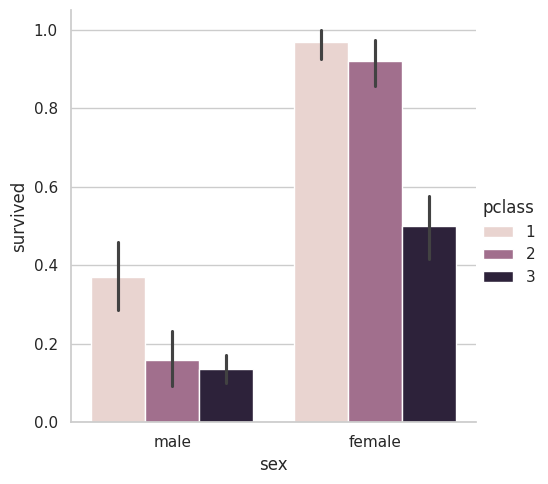

In [169]:
# Plot survival by class and sex
sns.set(style='whitegrid')
sns.catplot(x='sex', y='survived', hue='pclass', kind='bar', data=train)
plt.show()

The plot suggests that sex was more relevant than pclass in determining survival chances.

Most women in first (97%) and second (92%) class survived along with half (50%) of the women in third class. Few men survived. There was little difference between second class (16%) and third class (14%) survival for men. Even in first class, just over one third (37%) of men survived, a lower proportion than of women in third class.

Perhaps women were prioritized in the evacuation across all classes. Class was also a factor but not as much as sex.

## Age
To what degree is age a factor?

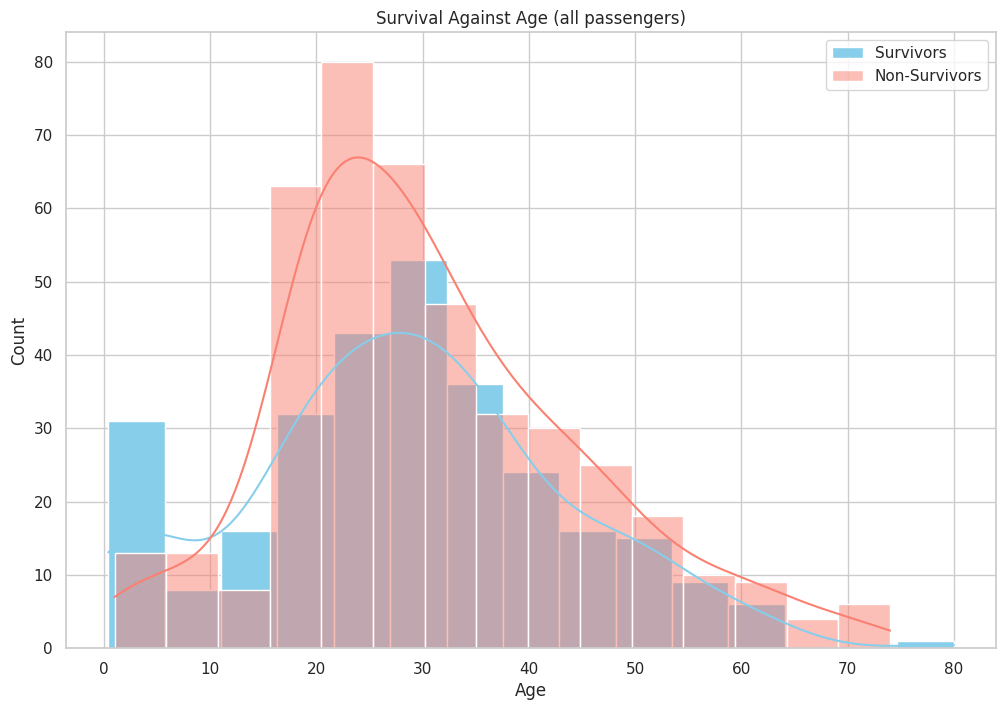

In [170]:
# Age disributions for survivor and non-survivor
survivors = train[(train.survived==1)]
non_survivors = train[(train.survived==0)]

sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.histplot(data=survivors, x='age', bins=15, kde=True, color='skyblue', label='Survivors', alpha=1)
sns.histplot(data=non_survivors, x='age', bins=15, kde=True, color='salmon', label='Non-Survivors', alpha=0.5)
plt.title('Survival Against Age (all passengers)')
plt.xlabel('Age')
plt.legend()
plt.show()

The difference in mean age of survivors (28) and non-survivors (31) is not large. The distributions are similar, although infants (under 10) might have had a greater chance of survival.

In [171]:
print(f'Average age: {data.age.mean():.0f}')
print(f'Average age survivors: {data[data.survived == 1].age.mean():.0f}')
print(f'Average age non-survivors: {data[data.survived == 0].age.mean():.0f}')

Average age: 30
Average age survivors: 28
Average age non-survivors: 31


However age distributions were not the same across pclass. If lower pclass (i.e. first class) and lower age were both correlated with greater chance of survival, yet pclass and age are negatively correlated with each other, that could be minimising the effect of age on survival overall.

Explore age against pclass.

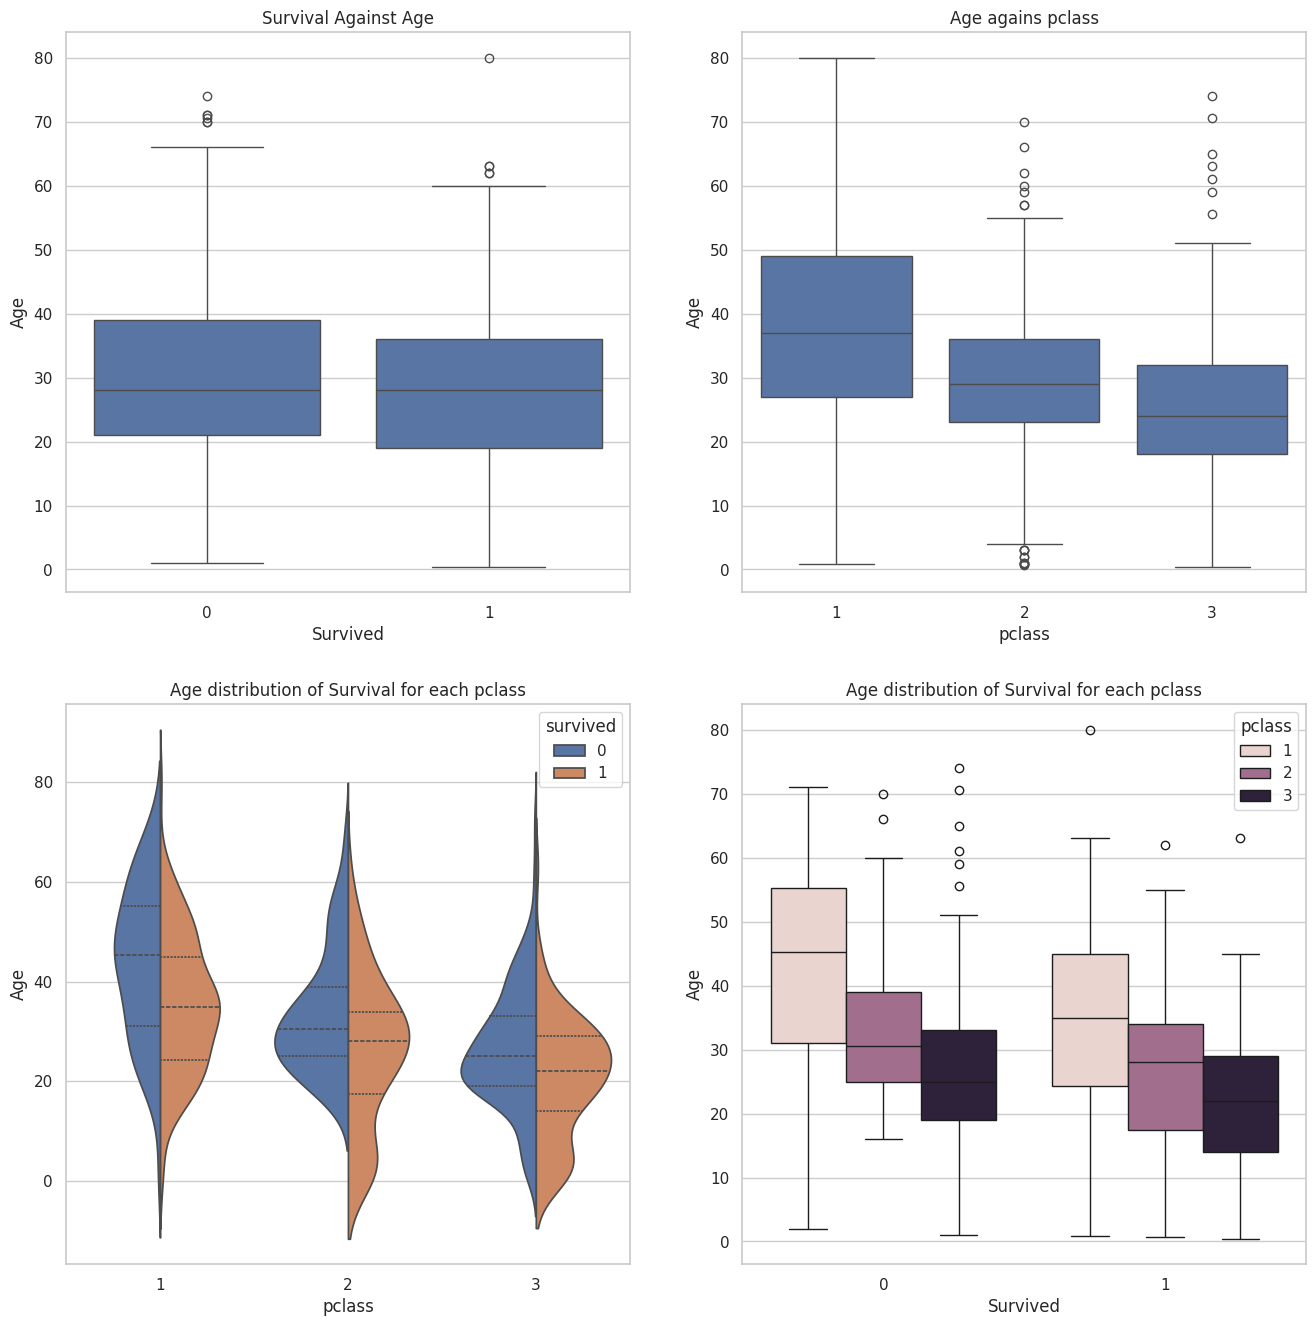

In [172]:
# Boxplot for age against survived
sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# All ages
sns.boxplot(x='survived', y='age', data=train, ax=axes[0,0])
axes[0,0].set_title('Survival Against Age')
axes[0,0].set_xlabel('Survived')
axes[0,0].set_ylabel('Age')

# Age against pclass
sns.boxplot(x='pclass', y='age', data=train, ax=axes[0,1])
axes[0,1].set_title('Age agains pclass')
axes[0,1].set_xlabel('pclass')
axes[0,1].set_ylabel('Age')

# Violin plot on pclass
sns.violinplot(x="pclass", y="age", hue="survived", data=train, split=True, inner='quart', ax=axes[1,0])
axes[1,0].set_title('Age distribution of Survival for each pclass')
axes[1,0].set_xlabel('pclass')
axes[1,0].set_ylabel('Age')

# Box plot on pclass
sns.boxplot(x='survived', y='age', hue='pclass', data=train, ax=axes[1,1])
axes[1,1].set_title('Age distribution of Survival for each pclass')
axes[1,1].set_xlabel('Survived')
axes[1,1].set_ylabel('Age')

plt.show()

Age is a factor but it is only obvious when combined with pclass. There certainly appears to be a relatively high chance of survival for infant children (around age 10).

In [173]:
def age_group_survival(child=5, elderly=50):
  print(f'Children defind as {child} and under')
  print(f'Elderly defind as {elderly} and over\n')
  # Overall survival by pclass
  total_by_class = train.groupby('pclass')['passengerid'].count()
  survived_by_class = train[train.survived == 1].groupby('pclass')['passengerid'].count()

  # Child survival by pclass
  infant_total_by_class = train[train.age <= child].groupby('pclass')['passengerid'].count()
  infant_survived_by_class = train[(train.age <= child) & (train.survived == 1)].groupby('pclass')['passengerid'].count()

  # Elderly survival by pclass
  elderly_total_by_class = train[train.age >= elderly].groupby('pclass')['passengerid'].count()
  elderly_survived_by_class = train[(train.age >= elderly) & (train.survived == 1)].groupby('pclass')['passengerid'].count()

  # Calculate and print
  for pclass, survived_count in survived_by_class.items():
    # overall counts and percents
    total_count = total_by_class.get(pclass)
    survival_percent = (survived_count / total_count) * 100 if total_count > 0 else 0
    # infant counts and percents
    infant_survived_count = infant_survived_by_class.get(pclass)
    infant_total_count = infant_total_by_class.get(pclass)
    infant_survival_percent = (infant_survived_count / infant_total_count) * 100 if total_count > 0 else 0
    # elderly counts and percents
    elderly_survived_count = elderly_survived_by_class.get(pclass)
    elderly_total_count = elderly_total_by_class.get(pclass)
    elderly_survival_percent = (elderly_survived_count / elderly_total_count) * 100 if total_count > 0 else 0
    # print results
    print(f'pclass {pclass}: Overall {survived_count}/{total_count} survived ({survival_percent:.0f}%)\
 | {infant_survived_count}/{infant_total_count} children ({infant_survival_percent:.0f}%)\
 | {elderly_survived_count}/{elderly_total_count} elderly ({elderly_survival_percent:.0f}%)')

age_group_survival(child=5, elderly=40)

Children defind as 5 and under
Elderly defind as 40 and over

pclass 1: Overall 136/216 survived (63%) | 2/3 children (67%) | 42/81 elderly (52%)
pclass 2: Overall 87/184 survived (47%) | 13/13 children (100%) | 16/37 elderly (43%)
pclass 3: Overall 119/491 survived (24%) | 16/28 children (57%) | 3/45 elderly (7%)


In [174]:
age_group_survival(child=10, elderly=50)

Children defind as 10 and under
Elderly defind as 50 and over

pclass 1: Overall 136/216 survived (63%) | 2/3 children (67%) | 20/44 elderly (45%)
pclass 2: Overall 87/184 survived (47%) | 17/17 children (100%) | 6/19 elderly (32%)
pclass 3: Overall 119/491 survived (24%) | 19/44 children (43%) | 1/11 elderly (9%)


In [175]:
age_group_survival(child=17, elderly=60)

Children defind as 17 and under
Elderly defind as 60 and over

pclass 1: Overall 136/216 survived (63%) | 11/12 children (92%) | 5/17 elderly (29%)
pclass 2: Overall 87/184 survived (47%) | 21/23 children (91%) | 1/4 elderly (25%)
pclass 3: Overall 119/491 survived (24%) | 29/78 children (37%) | 1/5 elderly (20%)


In addition to age combined with pclass generally being correlated with survival, infants were specificly likely to survive. Passengers with age over 60 were unlikely to survive for all pclass.

## Family Members
The plot below shows that men and women had a greater chance of survival when travelling with two siblings/spouce. However the chance of survival fell off steeply if travelling with three or more siblings/spouce.

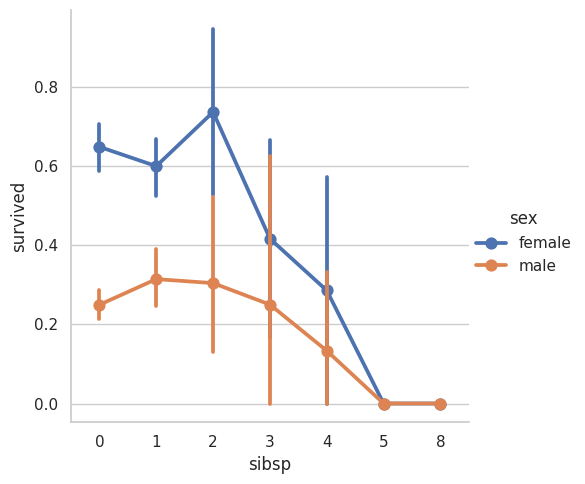

In [177]:
# Plot Survival against SibSp
sns.catplot(x='sibsp', y='survived', hue='sex', data=data, kind='point')
plt.show()

## Correlations
The largest correlation between numerical features and survival is with cabin class (-34%) and fare (26%). Correlation between age and survival is affected by the negative correlation between age and pclass. Sex is not encoded numerically yet.  

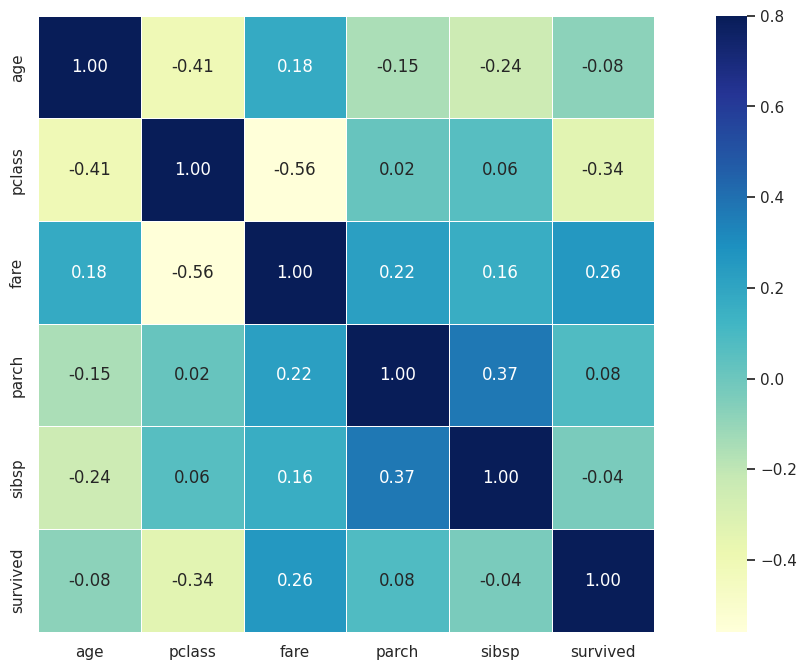

In [178]:
# Heartmap for numerical data
plt.figure(figsize=(16,8))
sns.heatmap(
    data[['age', 'pclass', 'fare', 'parch', 'sibsp', 'survived']].corr(),
    vmax=0.8,
    linewidths=0.5,
    fmt='.2f',
    square=True,
    annot=True,
    cmap='YlGnBu',
    linecolor='white')
plt.show()

# Feature Engineering

## New Features

Which new features can be created to enhance the models?

### Title
Extract the title of each passenger from their name. This might reflect social status within the cabin and have an impact on survival.

In [179]:
# Create a feature extracting title from name
data['title'] = data.name.str.extract(' ([A-Za-z]+)\.', expand=False)
#pd.pivot_table(data, index='title', aggfunc={'passengerid': 'count'})

# Consolidate broadly equivalent titles
data['title'] = data.title.replace('Mlle', 'Miss')
data['title'] = data.title.replace(['Mme', 'Dona', 'Ms'], 'Mrs')
data['title'] = data.title.replace('Don','Mr')
data['title'] = data.title.replace(['Capt','Rev','Major', 'Col','Dr'], 'Professional')
data['title'] = data.title.replace(['Lady', 'Countess','Sir','Jonkheer'], 'Honour')

In [180]:
# Show median age for passengers based on title and pclass
pd.pivot_table(data, index='title', values='age', columns='pclass', aggfunc='median')

pclass,1,2,3
title,,,
Honour,43.0,NaN,NaN
Master,6.0,2.0,6.0
Miss,30.0,20.0,18.0
Mr,41.0,30.0,26.0
Mrs,45.0,30.0,31.0
Professional,51.0,41.5,NaN


### Fare per Passenger

The fare apears to be for every passenger on the ticket. Create a fare per passenger.

In [181]:
# Calculate number of passengers on each ticket
num_passengers = data['ticket'].value_counts()

# Create mapping between ticket and number of passengers
num_passengers_map = dict(num_passengers)

# Divide fare by number of passengers on same ticket
data['fare_per_passenger'] = data.apply(lambda row: row['fare'] / num_passengers_map[row['ticket']], axis=1)

### Family Members

Passengers are travelling in family groups. Create a feature for the number of family members.

In [182]:
data['family_members'] = data.sibsp + data.parch

### Infants
Infants seemed to have an added survival chance. Create a categorical feature.

In [183]:
data['infant'] = data['age'].apply(lambda x: 1 if x <= 7 else 0)


## Missing Data
Deal with missing data in the features: age, cabin, fare, embarked.

**Embarked**

There are two NaNs in the embarked column. I do not want to create a new feature (increasing the dimensionality) for only two passengers. These are two women travelling on the same ticket and sharing cabin B28 in first class. Their names do not sound obviously French or Irish so, given that the majority of passengers embarked at Southhampton (70%) assign Southampton (S) as their port of embarkation.

In [184]:
data[data.embarked.isnull()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train,title,fare_per_passenger,family_members,infant
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,Miss,40.0,0,0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,Mrs,40.0,0,0


In [185]:
df = pd.pivot_table(data, index='embarked', aggfunc={'passengerid': 'count'})
southampton = df.loc['S'][0]
print(f'Passengers embarking at Southampton (S): {round(southampton / df.passengerid.sum()*100, 0)}%')
df

Passengers embarking at Southampton (S): 70.0%


,passengerid
embarked,
C,270
Q,123
S,914


In [186]:
# Fill embarked nans with 'S' for Southampton
data['embarked'] = data['embarked'].fillna('S')

**Cabin**

There are 982 missing values for Cabin (78% of rows). Potentially Cabin could be informative, since this would indicate the deck (perhaps proximity to lifeboats). There is no obvious way to infer the cabin from other data or to encode the cabin for training. However there could be a pattern to the passengers that do not have a recorded cabin. Create a categorical feature for whether the cabin was in the data or not.

In [187]:
# Create a new feature 'has_cabin' then drop 'cabin'
data['has_cabin'] = data['cabin'].apply(lambda x: 'yes' if pd.notna(x) else 'no')
data = data.drop('cabin', axis=1)

**Age**

Age was an important factor in survival (most infants survived). There are 263 rows (20%) with missing values of age. I want to keep age as continuous numerical data and not bin as categorical, so fill the nans with median values. Age varies across cabin class so use pclass and title to help fill missing ages.

**Age for passengers with the title *Miss***

There is a challenge in using the average age for passengers with the title "Miss". I can be certain that males with the title "Master" are infants -- they have an median age of six. Females with the title "Miss" could be either infants or unmarried adults. The median age for Miss in first class is 30.

There were 50 passengers with the title "Miss" of which 47 were in thrid class. The median age for "Miss" in third class was 18.75. I will use that value given I have no better value and do not want to delete 50 rows of data.

For Mr, Mrs, Miss and Master set NaNs in age to the median age for passengers with the same title and cabin class.

In [188]:
classes = [1,2,3]
titles = ['Mr', 'Mrs', 'Master', 'Miss']
for title in titles:
  for pclass in classes:
    ave_age = data[(data.pclass == pclass) & (data.title == title)].age.median()
    data.loc[(data.pclass == pclass) & (data.title == title) & (data.age.isnull()), 'age'] = ave_age

In [189]:
# Check for remaining age is nan
data.loc[data['age'].isnull()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,train,title,fare_per_passenger,family_members,infant,has_cabin
766,767,0.0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6,C,1,Professional,39.6,0,0,no


In [190]:
# Set to the median age for professionals in class 1
data.loc[data['age'].isnull(), 'age'] = data.loc[(data.title == 'Professional') & (data.pclass == 1)].age.median()

**Fare**

The only passenger where we do not know the fare paid is Mr Thomas Storey, a 60 year old man, travelling in third class. I will replace the null value with the median fare for passengers in third class with the title "Mr" (£7.90).



In [191]:
data[data.fare.isna()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,train,title,fare_per_passenger,family_members,infant,has_cabin
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0,Mr,NaN,0,0,no


In [192]:
data[(data.pclass == 3) & (data.title == 'Mr')].fare.median()

7.8958

In [193]:
data.fare.fillna(7.90, inplace = True)

## Categorical Age


In [194]:
# Define bin edges and labels
age_bins = [0, 15, 30, 50, float("inf")]
age_labels = ['0-14', '15-29', '30-49', '50+']

# Create a new column 'age_category' with bin labels based on 'age' column
data['age_category'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

## Interaction Terms
The data analysis suggested interaction between sex, cabin class and age. Add interaction terms for:
 * Sex and infant
 * Age and pclass
 * Fare and pclass
 * Sex and pclass

In [195]:
# Set interaction terms
data['sex_infant'] = data.sex.astype(str) + "_" + data.infant.astype(str)
data['age_category_pclass'] = data.age_category.astype(str) + "_" + data.pclass.astype(str)
data['sex_pclass'] = data.sex.astype(str) + "_" + data.pclass.astype(str)
data['fare_pclass'] = data.fare_per_passenger * data.pclass


Drop columns and encode



In [196]:
# Drop columns that cannot be easily encoded
data = data.drop(columns=['name', 'ticket'])

# One hot encode categorical data
columns=['pclass', 'sex', 'embarked', 'title', 'infant', 'has_cabin', 'age_category', 'sex_infant', 'age_category_pclass', 'sex_pclass']
data = pd.get_dummies(data, columns=columns)

# Lower case the column names
data.columns = data.columns.str.lower()

In [197]:
# Seperate the data back to train and test sets
train = data[data.train == 1].copy()
train = train.drop(columns=['train', 'passengerid'], axis=1)

test = data[data.train == 0].copy()
test = test.drop('train', axis=1)   # keep 'passengerid' for kaggle submission

In [198]:
# Create train and validation data sets
train_minus_val, val = train_test_split(train, test_size=0.2, random_state=42)
len(train_minus_val), len(val), len(test)

(712, 179, 418)

In [199]:
# Split into X and y data sets
y_train, y_val = train_minus_val.survived, val.survived
X_train, X_val = train_minus_val.drop('survived', axis=1), val.drop('survived', axis=1)

## Visualize Encoded Data
Visualize selected correlations

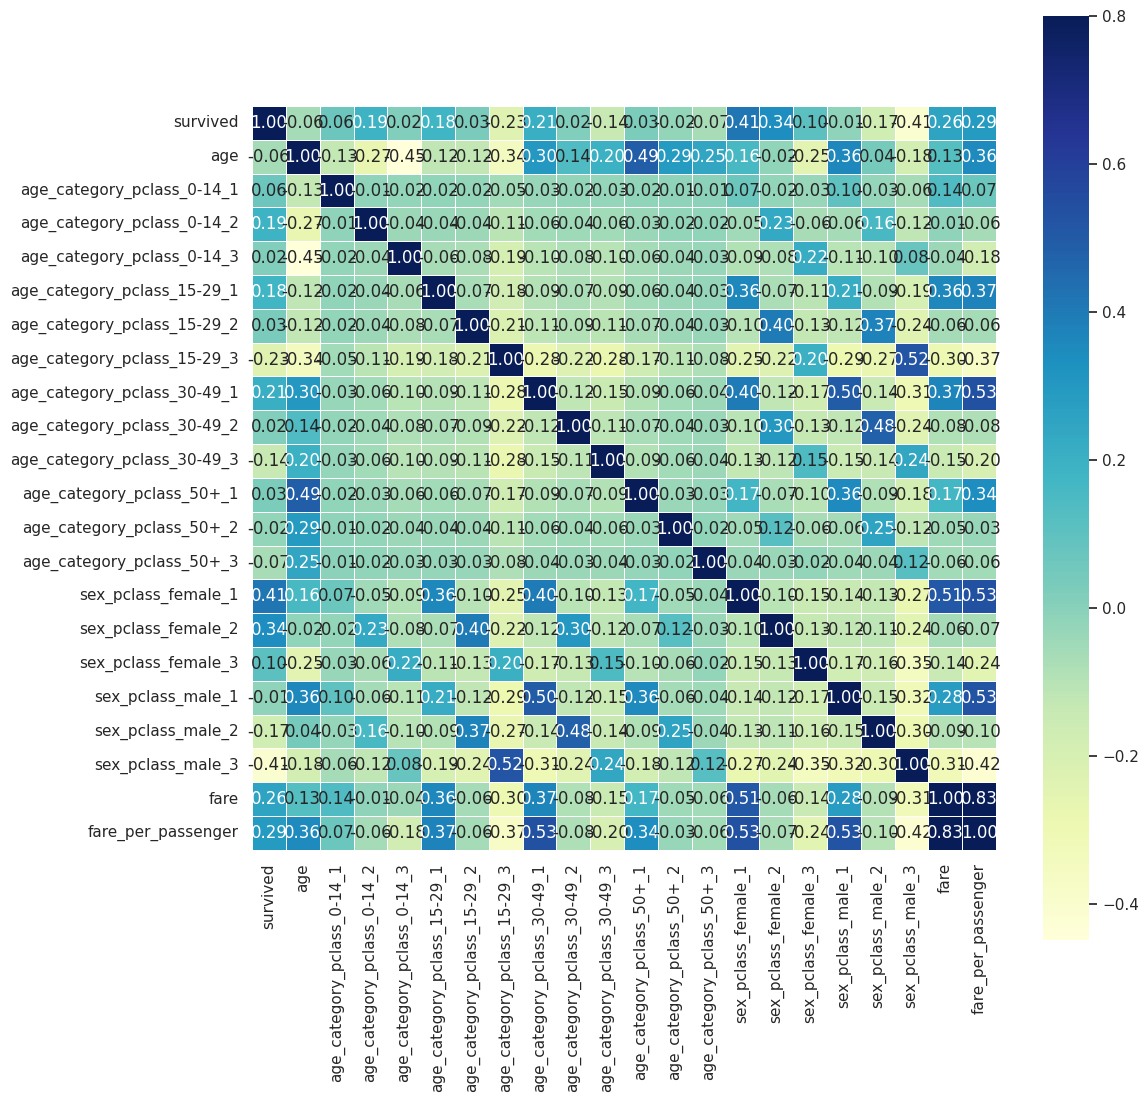

In [200]:
# Plot correlation as a heatmap
plt.figure(figsize=(12,12))
sns.heatmap(train[['survived', 'age', 'age_category_pclass_0-14_1', 'age_category_pclass_0-14_2',
       'age_category_pclass_0-14_3', 'age_category_pclass_15-29_1',
       'age_category_pclass_15-29_2', 'age_category_pclass_15-29_3',
       'age_category_pclass_30-49_1', 'age_category_pclass_30-49_2',
       'age_category_pclass_30-49_3', 'age_category_pclass_50+_1',
       'age_category_pclass_50+_2', 'age_category_pclass_50+_3',
       'sex_pclass_female_1', 'sex_pclass_female_2', 'sex_pclass_female_3',
       'sex_pclass_male_1', 'sex_pclass_male_2', 'sex_pclass_male_3', 'fare', 'fare_per_passenger']].corr(),
            vmax=0.8,
            linewidths=0.5,
            fmt='.2f',
            square=True,
            annot=True,
            cmap='YlGnBu',
            linecolor="white");

# Machine Learning

The most basic model is to predict that nobody survives. that has an accuracy of 61.1%.

A model that predicted all females survive and all males do not survive would be 74.2% accurate for females and 81.1% accurate for males.

In [201]:
# Set a random seed so that models can be tuned and compared
random_seed = 42

In [202]:
print(f'Simple Model 1 - Nobody survives:')
print(f'\t{round((1 - train.survived.mean())*100, 1)}% accurate\n')
print(f'Simple Model 2 - Females survive and males do not:')
print(f'\tFemales: {round(train[train.sex_female == 1].survived.mean()*100, 1)}%')
print(f'\tMales: {round((1 - train[train.sex_male == 1].survived.mean()) *100, 1)}%\n')
print(f'Simple Model 3 - Males over 10 years old do not survive, everyone else does:')
print(f'\tFemales: {round(train[train.sex_female == 1].survived.mean()*100, 1)}%')
print(f'\tMales: {round((1 - train[(train.sex_male == 1) & (train.age > 10)].survived.mean()) *100, 1)}%')

Simple Model 1 - Nobody survives:
	61.6% accurate

Simple Model 2 - Females survive and males do not:
	Females: 74.2%
	Males: 81.1%

Simple Model 3 - Males over 10 years old do not survive, everyone else does:
	Females: 74.2%
	Males: 83.7%


It can be seen that a simple decision tree based on male/female is already fairly accurate without applying any ML algorithms.

## Decision Tree

It looks like a simple decision tree starts to predict the survival. A decision tree might give good accuracy quite quickly. An added benefit is that the importance of featuress can be interpretted. Begin by training a DT without scaling the features so it can be interpretted.

In [203]:
# Create and train a decision tree classifier using sklearn
dt = DecisionTreeClassifier(random_state=random_seed)
dt.fit(X_train, y_train)

# Make predictions on the validation set and display accuracy
val_predictions = dt.predict(X_val)
accuracy = accuracy_score(y_val, val_predictions)
print(f'Validation accuracy: {round(accuracy*100, 1)}%')

Validation accuracy: 83.2%


The decision tree has an 83% accuracy on the validation data. However accuracy can be skewed when there is an imbalance between the number of outcomese we are predicting. In this case between the count of survived = 0 (62%) and survived = 1 (38%).

In [204]:
perc = round(train[train.survived == 1].survived.count()*100/len(train), 1)
print(f'Proportion that survived in the train data: {perc}%')

Proportion that survived in the train data: 38.4%


Area under ROC curve (AUC) will give an alternative measure of accuracy.

In [205]:
def calc_auc(model, X_train, y_train, X_val, y_val):
  # Use predict_proba to calculate AUC

  # Predict probabilities for the training set
  train_probabilities = dt.predict_proba(X_train)[:, 1]

  # Calculate training AUC
  train_auc = roc_auc_score(y_train, train_probabilities)

  # Predict probabilities for the validation set
  val_probabilities = model.predict_proba(X_val)[:, 1]

  # Calculate validation AUC
  val_auc = roc_auc_score(y_val, val_probabilities)

  return(train_auc, val_auc)

train_auc, val_auc = calc_auc(dt, X_train, y_train, X_val, y_val)

print(f'Training data AUC:\t{round(train_auc*100, 1)}%')
print(f'Validation data AUC:\t{round(val_auc*100, 1)}%')

Training data AUC:	99.9%
Validation data AUC:	83.1%


***Overfitting***

The AUC score is 99.9% for the training data and 83% for the validation data. The model is remembering the data. The data set is too small and the model is too complex. This model might not generalize very well against the unseen Test data.

### Hyper-parameter Tuning
Use GridSearchCV from scikit-learn to tune hyper-parameters using cross-validation.

In [206]:
### Define the hyperparameters and their possible values
param_grid = {
    'max_depth': [1, 2, 3, 5, 10],
    'min_samples_leaf': [15, 20, 40],
    'min_samples_split': [50, 100, 200],
}

# Create Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding accuracy score
print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Best Accuracy: {grid_search.best_score_*100:.1f}%')

Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 50}
Best Accuracy: 81.9%


In [207]:
# Calculate accuracy against validation data
val_predictions = grid_search.predict(X_val)
accuracy = accuracy_score(y_val, val_predictions)

# Calculate train AUC
train_probabilities = grid_search.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, train_probabilities)

# Calculate validation AUC
val_probabilities = grid_search.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_probabilities)

print(f'Validation accuracy:\t{accuracy*100:.1f}%')
print(f'Training data AUC:\t{train_auc*100:.1f}%')
print(f'Validation data AUC:\t{val_auc*100:.1f}%')

Validation accuracy:	79.9%
Training data AUC:	88.1%
Validation data AUC:	86.0%


Parameter tuning has improved the AUC against the validation data from 83% to 86%, which is now inline with a training data AUC of 88%. The accuracy against the validation data is decreased from 83% to 80%, but the model is much more likely to generalize.

Plot the ROC curve and confusion table for this model. Calculate the precision, recall and F1 scores.

AUC: 86.0%


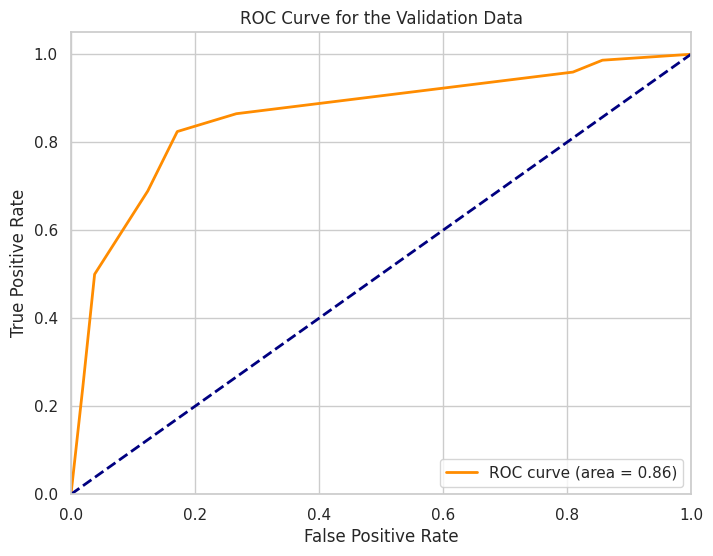

In [208]:
# Define parameters
max_depth = grid_search.best_params_['max_depth']
min_samples_leaf = grid_search.best_params_['min_samples_leaf']
min_samples_split = grid_search.best_params_['min_samples_split']

# Fit Decision Tree using tuned parameters
dt = DecisionTreeClassifier(
  max_depth=max_depth,
  min_samples_leaf=min_samples_leaf,
  min_samples_split=min_samples_split,
  random_state=random_seed
)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc*100:.1f}%')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for the Validation Data')
plt.legend(loc='lower right')
plt.show()

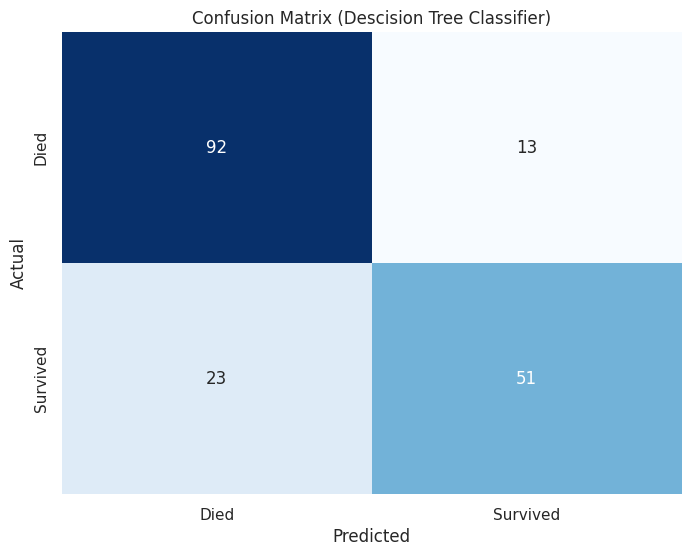

In [209]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_val, val_predictions)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap='Blues', cbar=False,
            annot_kws={"size": 12},
            xticklabels=['Died', 'Survived'],
            yticklabels=['Died', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Descision Tree Classifier)')
plt.show()

In [210]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_val, val_predictions)
recall = recall_score(y_val, val_predictions)
f1 = f1_score(y_val, val_predictions)

# Display precision, recall, and F1-score
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

Precision: 0.797%
Recall: 0.689
F1-score: 0.739


An F1 score of 0.74 is not too bad.

Tuning has made the model generalize much better. To explore how parameter tuning has generalized the model investigate the max_depth parameter.

In [211]:
def fit_dt(X_train, y_train, X_val, y_val, max_depth=10):
  # Create a decision tree with max_depth
  dt = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    random_state=random_seed
  )
  dt.fit(X_train, y_train)

  # Calculate accuracy
  val_predictions = dt.predict(X_val)
  accuracy = accuracy_score(y_val, val_predictions)

  # Calculate train AUC
  train_probabilities = dt.predict_proba(X_train)[:, 1]
  train_auc = roc_auc_score(y_train, train_probabilities)

  # Calculate validation AUC
  val_probabilities = dt.predict_proba(X_val)[:, 1]
  val_auc = roc_auc_score(y_val, val_probabilities)

  return(accuracy, train_auc, val_auc)

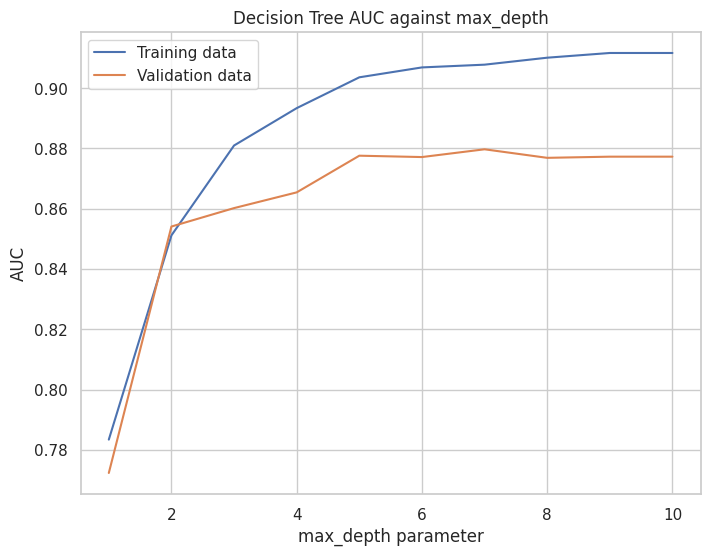

In [212]:
# Train the decision tree model with different values of max_depth
depth_arr, auc_train, auc_val, acc_val = [], [], [], []

for depth in np.arange(1, 11):
  depth_arr.append(depth)
  acc, auct, aucv = fit_dt(X_train, y_train, X_val, y_val, max_depth=depth)
  auc_train.append(auct)
  auc_val.append(aucv)
  acc_val.append(acc)

# Plot AUC against max_depth of the DT
plt.figure(figsize=(8, 6))
plt.plot(depth_arr, auc_train, label='Training data')
plt.plot(depth_arr, auc_val, label='Validation data')
plt.xlabel('max_depth parameter')
plt.ylabel('AUC')
plt.title('Decision Tree AUC against max_depth')
plt.legend()
plt.show;

The maximum AUC on the validation data is for max_depth=7, but the model is overfitting at this point. With a max depth of 3 we already see the AUC for the validation data is reaching a around 86%, with an accuracy of around 80%.

### Interpret the Decision Tree
A textual representation of the model shows the most prominent features.

In [213]:
# Generate the textual representation of the decision tree
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

tree_rules = export_text(dt, feature_names=list(X_train.columns))
print(tree_rules)

|--- sex_infant_male_0 <= 0.50
|   |--- pclass_3 <= 0.50
|   |   |--- age_category_pclass_0-14_1 <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- age_category_pclass_0-14_1 >  0.50
|   |   |   |--- class: 1.0
|   |--- pclass_3 >  0.50
|   |   |--- fare <= 23.35
|   |   |   |--- class: 1.0
|   |   |--- fare >  23.35
|   |   |   |--- class: 0.0
|--- sex_infant_male_0 >  0.50
|   |--- fare_per_passenger <= 24.56
|   |   |--- age_category_pclass_0-14_2 <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- age_category_pclass_0-14_2 >  0.50
|   |   |   |--- class: 1.0
|   |--- fare_per_passenger >  24.56
|   |   |--- fare <= 387.66
|   |   |   |--- class: 0.0
|   |   |--- fare >  387.66
|   |   |   |--- class: 1.0



The **first** split is on sex_infant_male_0. This is branching adult (and teen) males from everyoine else.

We expected sex to be the key feature from the initial analysis. By splitting on sex_infant_male_0 instead of male the model has identified that infant males mostly survived.

For females and male infants, the **second** split is for pclass = 3. For those in pclass 1 or 2, the model predicts survival. For those in pclass 3, the model makes a final split. The **third** split is for fare greater than 23.35. The model predicts that those with a fare below 23.35 survive and those with a greater fare do not survive. The initial analysis showed fare correlated with number of passengers traveling on the same ticket. The model seems to be identifying fare > 23.35 as a proxy for the size of a large group travelling togeather.

For adult males, the **second** split is for fare_per_passenger. For those with a fare_per_passenger less than 24.56, the **third** split predicts those in age group 0-14 and pclass 2 survive and others do not. For those with a fare_per_passenger greater than 24.56, the **third** split predicts those with a fare greater than 387.66 survive and those without do not. This final combination of fare_per_passenger and fare for adult males is proxying a more expensive personal ticket and a larger traveling group as a predictor for survival.

In summary, females and males under the age of 15 are predicted to survive unless they are travelling in third class in a large group. Males over the age of 14 are predicted not to survive unless they are tavelling in a larger group on an expensive ticket. There are only two adult males with a fare greater the 387.66 in the training data: Thomas Cardeza and his man servant Gustave Lesurer! The model predicts that every other male over the age of 14 will not survive.

It does look like **women and children first** was a good hypothesis!

Note that engineered features are being heavily used by the decision tree.

In [214]:
df = pd.read_csv('train.csv')
df[(df.Sex == 'male') & (df.Fare > 387.66)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [215]:
importances = pd.DataFrame({'feature': X_train.columns,'importance': np.round(dt.feature_importances_, 5)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(10)

,importance
feature,
sex_infant_male_0,0.65420
pclass_3,0.19441
fare,0.09026
fare_per_passenger,0.04929
age_category_pclass_0-14_2,0.00954
age_category_pclass_0-14_1,0.00230
age,0.00000
age_category_pclass_30-49_1,0.00000
sex_infant_female_0,0.00000


## Compare Scikit-learn Alogrthims (with default hyper-parameters)
Scikit-learn provides a number of algorithms for training models. We can loop through them all to see if any particular algorithms over perform the others.  

In [216]:
random_seed = 42

In [217]:
# Scale the data
X_train_df = X_train.copy()
X_val_df = X_val.copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [218]:
def append_acc(algo_name, acc_train, acc_val):
  model_type.append(algo_name)
  accuracies_train.append(acc_train)
  accuracies_val.append(acc_val)

In [219]:
model_type, accuracies_train, accuracies_val = [], [], []

# Stochastic Gradient Descent (SGD)
sgd = linear_model.SGDClassifier(tol=None, random_state=random_seed)
sgd.fit(X_train, y_train)

# Predict for validation data
y_pred = sgd.predict(X_val)

# Get Accuracies
acc_train = sgd.score(X_train, y_train)
acc_val = accuracy_score(y_val, y_pred)
append_acc('Stochastic Gradient Descent', acc_train, acc_val)

#####

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=random_seed)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_val)

acc_train = random_forest.score(X_train, y_train)
acc_val = accuracy_score(y_val, y_pred)
append_acc('Random Forest', acc_train, acc_val)

#####

# Logistic Regression
logreg = LogisticRegression(random_state=random_seed)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_val)

acc_train = logreg.score(X_train, y_train)
acc_val = accuracy_score(y_val, y_pred)
append_acc('Logistic Regression', acc_train, acc_val)

#####

# K Nearest Neighbour
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)

acc_train = knn.score(X_train, y_train)
acc_val = accuracy_score(y_val, y_pred)
append_acc('K Nearest Neighbour', acc_train, acc_val)

#####

# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)

y_pred = gaussian.predict(X_val)

acc_train = gaussian.score(X_train, y_train)
acc_val = accuracy_score(y_val, y_pred)
append_acc('Gaussian Naive Bayes', acc_train, acc_val)

#####

# Perceptron
perceptron = Perceptron(random_state=random_seed)
perceptron.fit(X_train, y_train)

y_pred = perceptron.predict(X_val)

acc_train = perceptron.score(X_train, y_train)
acc_val = accuracy_score(y_val, y_pred)
append_acc('Perceptron', acc_train, acc_val)

#####

# Linear Support Vector Machine
linear_svc = LinearSVC(max_iter=2000, random_state=random_seed)
linear_svc.fit(X_train, y_train)

y_pred = linear_svc.predict(X_val)

acc_train = linear_svc.score(X_train, y_train)
acc_val = accuracy_score(y_val, y_pred)
append_acc('Linear Support Vector Machine', acc_train, acc_val)

#####

# Decision Tree
decision_tree = DecisionTreeClassifier(random_state=random_seed)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_val)

acc_train = decision_tree.score(X_train, y_train)
acc_val = accuracy_score(y_val, y_pred)
append_acc('Decision Tree', acc_train, acc_val)

# Show all results
results = pd.DataFrame({
    'Model': model_type,
    'Train Accuracy': accuracies_train,
    'Validation Accuracy': accuracies_val})
results = results.sort_values(by='Validation Accuracy', ascending=False)
results.head(15)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Model,Train Accuracy,Validation Accuracy
1,Random Forest,0.984551,0.843575
3,K Nearest Neighbour,0.860955,0.837989
7,Decision Tree,0.984551,0.832402
2,Logistic Regression,0.846910,0.826816
6,Linear Support Vector Machine,0.844101,0.821229
0,Stochastic Gradient Descent,0.820225,0.793296
5,Perceptron,0.787921,0.787709
4,Gaussian Naive Bayes,0.813202,0.782123


From this quick analysis the alogorithms are mostly training models with around 79-81% accuracy on the validation data (without regularization or parameter tuning).

Rnadom Forests and Decision Trees (and to a lesser extent K Nearest Neighbours) overfit the data. The Decision Tree only has a validation accuracy of 66%, but after regularizing and tuning this was increased to 80%, with an AUC of 86% (against unscaled validation data).

Is it possible to beat that for selected models here?

## Tuning Model Hyperparameters

In [220]:
def tune_model(classifier, param_grid):
  # Tune parameters for a classifier

  # Grid Search
  print('Tuning model paramters...')
  grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5)
  grid_search.fit(X_train, y_train)

  # Get the best parameters and best model
  best_params = grid_search.best_params_
  best_model = grid_search.best_estimator_

  # Make predictions on the validation data
  y_pred = best_model.predict(X_val)

  # Calculate accuracy on the validation data
  accuracy = accuracy_score(y_val, y_pred)
  print(f'Best Parameters: {best_params}')
  print(f'Accuracy on Validation Data: {accuracy*100:.1f}%')

  # Calculate train AUC
  y_train_probs = best_model.predict_proba(X_train)[:, 1]
  train_auc = roc_auc_score(y_train, y_train_probs)

  # Calculate validation AUC
  y_val_probs = best_model.predict_proba(X_val)[:, 1]
  val_auc = roc_auc_score(y_val, y_val_probs)

  print(f'Training data AUC:\t{train_auc*100:.2f}%')
  print(f'Validation data AUC:\t{val_auc*100:.2f}%')

  # Calculate false/true positive rates
  val_fpr, val_tpr, _ = roc_curve(y_val, y_val_probs)
  train_fpr, train_tpr, _ = roc_curve(y_train, y_train_probs)

  # Define Plots
  sns.set(style='whitegrid')
  # Plot ROC Curve
  sns.lineplot(x=val_fpr, y=val_tpr, color='black', linestyle='solid', linewidth=2, label=f'Validation (AUC = {val_auc:.2f})')
  sns.lineplot(x=train_fpr, y=train_tpr, color='black', linestyle='dashed', linewidth=2, label=f'Train (AUC = {train_auc:.2f})')
  sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--', linewidth=1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.show()

  return(best_model, best_params, train_auc, val_auc, accuracy)

In [221]:
tuned_results = pd.DataFrame(columns=['Model', 'Train AUC', 'Val AUC', 'Val Accuracy', 'Best Params'])

### K Nearest Neighbours
K Nearest Neighbours had an accuracy of 79% against the validation data using default parameters. The model looked to be overfitting on the training data so there might be an opportunity to improve performance with tuning.


Tuning model paramters...
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Accuracy on Validation Data: 84.4%
Training data AUC:	92.22%
Validation data AUC:	90.05%


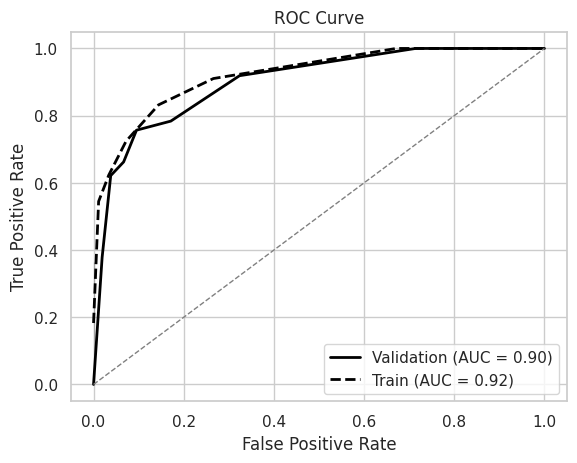

,Model,Train AUC,Val AUC,Val Accuracy,Best Params
0,KNeighborsClassifier,0.922184,0.900515,0.843575,"{'algorithm': 'auto', 'n_neighbors': 7, 'weigh..."


In [222]:
# KNN classifier
classifier = KNeighborsClassifier()

# Define parameter grid
param_grid = {
    'n_neighbors': [5, 7, 9, 11],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm to compute nearest neighbors
}

# Tune the model
best_knn, best_knn_params, train_auc, val_auc, accuracy = tune_model(classifier=classifier, param_grid=param_grid)

# Add results to summary table
results = ['KNeighborsClassifier', train_auc, val_auc, accuracy, best_knn_params]
tuned_results.loc[len(tuned_results)] = results

tuned_results


### Logistic Regression
With default paarameters the logistic regression algorithm found an accuracy of 80% against the validation data.



Tuning model paramters...
Best Parameters: {'C': 1, 'max_iter': 400}
Accuracy on Validation Data: 82.7%
Training data AUC:	88.77%
Validation data AUC:	88.55%


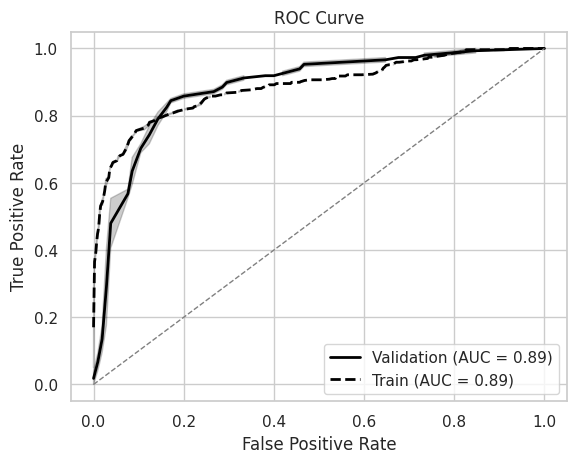

,Model,Train AUC,Val AUC,Val Accuracy,Best Params
0,KNeighborsClassifier,0.922184,0.900515,0.843575,"{'algorithm': 'auto', 'n_neighbors': 7, 'weigh..."
1,LogisticRegression,0.887665,0.885457,0.826816,"{'C': 1, 'max_iter': 400}"


In [223]:
# Create a Logistic Regression model
classifier = LogisticRegression(random_state=random_seed)

# Define parameter grid
param_grid = {
    'C': [1, 10, 50],  # Regularization parameter
    'max_iter': [400, 500, 600]  # Maximum number of iterations for optimization
}

# Tune the model
best_logreg, best_logreg_params, train_auc, val_auc, accuracy = tune_model(classifier=classifier, param_grid=param_grid)

# Add results to summary table
results = ['LogisticRegression', train_auc, val_auc, accuracy, best_logreg_params]
tuned_results.loc[len(tuned_results)] = results

tuned_results

### Stochastic Gradient Descent
With default paarameters the Stochastic Gradient Descent algorithm found an accuracy of 80% against the validation data.


Tuning model paramters...
Best Parameters: {'alpha': 0.0001, 'loss': 'log_loss', 'penalty': 'l2'}
Accuracy on Validation Data: 82.7%
Training data AUC:	88.51%
Validation data AUC:	87.80%


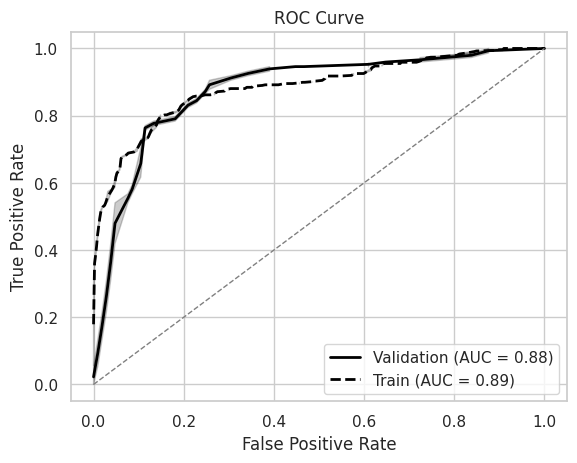

,Model,Train AUC,Val AUC,Val Accuracy,Best Params
0,KNeighborsClassifier,0.922184,0.900515,0.843575,"{'algorithm': 'auto', 'n_neighbors': 7, 'weigh..."
1,LogisticRegression,0.887665,0.885457,0.826816,"{'C': 1, 'max_iter': 400}"
2,SGDClassifier,0.885127,0.877992,0.826816,"{'alpha': 0.0001, 'loss': 'log_loss', 'penalty..."


In [224]:
# Create a Stochastic Gradient Descent model
classifier = SGDClassifier(tol=None, random_state=random_seed)

# Define parameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'loss': ['log_loss', 'modified_huber', 'squared_hinge'],  # Loss functions
    'penalty': ['l1', 'l2', 'elasticnet']  # Regularization types
}

# Tune the model
best_sgd, best_sgd_params, train_auc, val_auc, accuracy = tune_model(classifier=classifier, param_grid=param_grid)

# Add results to summary table
results = ['SGDClassifier', train_auc, val_auc, accuracy, best_sgd_params]
tuned_results.loc[len(tuned_results)] = results

tuned_results

### Random Forest
With default paarameters the Random Forest algorithm found an accuracy of 73% against the validation data, although we know that a Decsion Tree could be significantly improved. However, not many of the features in the Decsioin Tree were of great importance so there could be a limit on how much a Random Forest can improve on a single tree.

Tuning model paramters...
Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 50}
Accuracy on Validation Data: 79.9%
Training data AUC:	88.92%
Validation data AUC:	88.53%


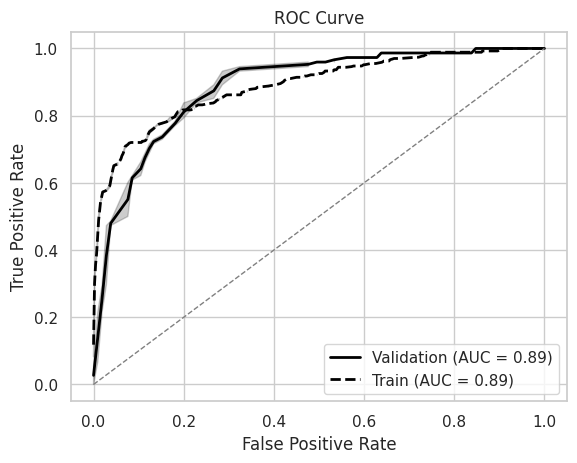

,Model,Train AUC,Val AUC,Val Accuracy,Best Params
0,KNeighborsClassifier,0.922184,0.900515,0.843575,"{'algorithm': 'auto', 'n_neighbors': 7, 'weigh..."
1,LogisticRegression,0.887665,0.885457,0.826816,"{'C': 1, 'max_iter': 400}"
2,SGDClassifier,0.885127,0.877992,0.826816,"{'alpha': 0.0001, 'loss': 'log_loss', 'penalty..."
3,RandomForestClassifier,0.889190,0.885264,0.798883,"{'max_depth': 5, 'max_features': 'sqrt', 'min_..."


In [225]:
# Create a RandomForestClassifier model
classifier = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [25, 50, 75],
    'max_depth': [2, 3, 5],
    'min_samples_split': [50, 75],
    'min_samples_leaf': [10, 20],
    'max_features': ['log2', 'sqrt']
}

# Tune the model
best_rf, best_rf_params, train_auc, val_auc, accuracy = tune_model(classifier=classifier, param_grid=param_grid)

# Add results to summary table
results = ['RandomForestClassifier', train_auc, val_auc, accuracy, best_rf_params]
tuned_results.loc[len(tuned_results)] = results

tuned_results

### Results
The K Nearest Neighbours algorithm trained the most accurate model, with 82.7% accuracy against the validation data. However it does look like that model might be slightly overfitting the training data.

The Stocastic gradient Descent algorithm had an accuracy of 82.1% and the AUC against the training data (0.887) is closer aligned to the validation data (also 0.887).

The Random Forest did not improve on the Decsion Tree for accuracy, although it does have a greater AUC.

## Neural Network


In [226]:
def make_deep_model(dense_layers=1, num_nodes=64, dropouts=[], dropout=0.0, learning_rate=0.001):
  """
  Function to built and compile a model using Keras
  _______________________________________________________
    Parameters:
      input_shape           :
      num_layers (int)      : Number of hidden dense layers
      nodes (int)           : Number of nodes in each dense layer
      dropout (float)       : Dropout to apply to each dense layer, in the range 0.0 to 1.0
      learning_rate (float) : The Learning Rate
  _______________________________________________________
    Returns                       : Keras model
  """
  # Input layer
  input_shape = (X_train.shape[1],)
  layers = [Dense(128, input_shape=input_shape, activation='relu')]

  # Dense layers
  # Handle configuring identical or varying dense layers
  if isinstance(dense_layers, list):
    i=0
    for nodes in dense_layers:
      layers.append(Dense(nodes, activation='relu'))
      layers.append(Dropout(dropouts[i]))
      i+=1

  elif isinstance(dense_layers, int):
    for _ in range(dense_layers):
      layers.append(Dense(num_nodes, activation='relu'))
      layers.append(Dropout(dropout))

  # Output layer
  layers.append(Dense(1, activation='sigmoid'))

  # Define parameters and compile the model
  optimizer = Adam(learning_rate)
  loss = BinaryCrossentropy()

  # Build sequential model and compile
  model = Sequential(layers)
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])

  return(model)

In [227]:
def plot_accuracy(history, plot_title, fpr_train, tpr_train, fpr_val, tpr_val, auc_train, auc_val):
  """
  Function to plot the accuracy and ROC curve of the model against validation data
  _______________________________________________________
    Parameters:
      history (keras history)    : Keras history data from model training
      title (string)             : Title to display with the plot
  _______________________________________________________
    Returns                    : Keras model

  """
  # Data to plot
  epochs = history.epoch
  val_acc = history.history['val_accuracy']
  val_max_acc = max(val_acc)
  train_acc = history.history['accuracy']

  # Define Plots
  sns.set(style='whitegrid')
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

  # Plot Accuracy
  sns.lineplot(x=epochs, y=val_acc, color='black', linestyle='solid', label=f'Validation (accuracy = {val_max_acc*100:.1f}%)', ax=axes[0])
  sns.lineplot(x=epochs, y=train_acc, color='black', linestyle='dashed', label='Train', ax=axes[0])
  axes[0].set_title(plot_title)
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Accuracy')
  axes[0].legend(loc='lower right')

  # Plot ROC Curve
  sns.lineplot(x=fpr_val, y=tpr_val, color='black', linestyle='solid', linewidth=2, label=f'Validation (AUC = {auc_val:.2f})', ax=axes[1])
  sns.lineplot(x=fpr_train, y=tpr_train, color='black', linestyle='dashed', linewidth=2, label=f'Train (AUC = {auc_train:.2f})', ax=axes[1])
  sns.lineplot(x=[0, 1], y=[0, 1], color='gray', linestyle='--', linewidth=1, ax=axes[1])
  axes[1].set_xlabel('False Positive Rate')
  axes[1].set_ylabel('True Positive Rate')
  axes[1].set_title('ROC Curve')
  axes[1].legend(loc='lower right')

  plt.savefig(f'{history}.png')
  plt.show()


In [228]:
def set_checkpoint():
  """
  Function to define a Keras ModelCheckpoint callback. This will
  save the model to disk if an epoch improves on all previous
  accuracy against the validation data.
  _______________________________________________________
    Parameters:
  _______________________________________________________
    Returns                 : Keras ModelCheckpoint callback

  """
  model_name = 'keras_ver_unknown_ep{epoch:0d}_acc{val_accuracy:.3f}.h5'
  checkpoint = ModelCheckpoint(
      filepath=model_name,
      save_best_only=True,
      monitor='val_accuracy',
      verbose=1
  )
  return(checkpoint)

def set_learning_rate_reduction():
  """
  Function to define a Keras ReduceLROnPlateau callback. This will
  reduce the learning rate if the model is begining to stop learning.
  _______________________________________________________
    Parameters:
  _______________________________________________________
    Returns                 : Keras ReduceLROnPlateau callback

  """
  learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.5,
    min_lr=0.00001,
    verbose=1
  )
  return(learning_rate_reduction)

def set_early_stoping(patience=5, monitor='val_loss', restore_best_weights=True, verbose=1):
  """
  Function to define a Keras EarlyStopping callback. This will stop
  the model training if the accuracy against validation data is not
  improving
  _______________________________________________________
    Parameters:
  _______________________________________________________
    Returns                 : Keras EarlyStopping callback

  """
  early_stoping = EarlyStopping(
    patience=patience,
    monitor=monitor,
    restore_best_weights=restore_best_weights,
    verbose=verbose
  )
  return(early_stoping)

In [229]:
model_ver='vX'
def execute_training(
  X_train,
  y_train,
  X_val,
  y_val,
  model_ver='vX',
  plot_title=f'Keras model: {model_ver}',
  dense_layers=128,
  num_nodes=1,
  dropout=0,
  dropouts=[0],
  batch_size = 64,
  epochs = 20,
  learning_rate = 0.001,
  callbacks = []
):
  """
  Function to define, fit and plot the accuracy of a model.
  _______________________________________________________
    Parameters:
      model_ver (string)    : Model version used for lables
      plot_title (string)   : Title of the plot
      dense_layers (list/int)
                            : List of ints or a single int. With a single int,
                              the int is the total number of identical dense
                              layers, to be used with the arguments num_nodes
                              and dropout. With a list, each element is the
                              number of nodes in a new dense layer. To be used
                              the argument dropouts.
      num_nodes (int)       : Number of nodes in each identical dense layer. Used
                              when dense_layers is a single int.
      dropout (float)       : Float between 0.0 - 1.0 that gives the dropout for
                              identical dense layers. Used when dense_layers is
                              a single int.
      dropouts (list)       : List of floats 0.0 - 1.0. Each is the dropout for
                              a dense layer specified when dense_layers is a list.
      batch_size (int)      : Images to input at each step of the epoch
      epochs (int)          : Number of epochs
      learning_rate (float) : Learning rate for the model
  _______________________________________________________
    Returns                       : History array for the epochs
                                  : The model
  """

  # Create the model
  model = make_deep_model(
    dense_layers=dense_layers,
    num_nodes=num_nodes,
    dropouts=dropouts,
    dropout=dropout,
    learning_rate=learning_rate
  )

  # Print the model
  print(model.summary())

  # Fit the model
  history = model.fit(
      X_train,
      y_train,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=(X_val, y_val)
  )

  # Calculate True/False Positive Rates
  fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train).ravel())
  fpr_val, tpr_val, _ = roc_curve(y_val, model.predict(X_val).ravel())

  # Calculate AUCs
  auc_train = auc(fpr_train, tpr_train)
  auc_val = auc(fpr_val, tpr_val)

  # Plot the accuracy
  plot_accuracy(history, plot_title, fpr_train, tpr_train, fpr_val, tpr_val, auc_train, auc_val)

  # Add results to summary table
  accuracy_val = max(history.history['val_accuracy'])*100
  results = [model_ver, dense_layers, num_nodes, dropout, learning_rate, accuracy_val, auc_train, auc_val]
  nn_results.loc[len(nn_results)] = results

  return(history, model)

In [230]:
nn_results = pd.DataFrame(columns=['Model', 'Dense Layers', 'Nodes', 'Dropout', 'LR', 'Accuracy', 'Train AUC', 'Val AUC'])

### V1 - Simple Neural Network

First, train a neural network with a single hidden dense layer with 128 nodes.

Training the model on the same training data, gives an accuracy of around 85% on thre validation data, with training and validation AUCs of around 91% and 90%.

Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_495 (Dense)           (None, 128)               6656      
                                                                 
 dense_496 (Dense)           (None, 128)               16512     
                                                                 
 dropout_273 (Dropout)       (None, 128)               0         
                                                                 
 dense_497 (Dense)           (None, 1)                 129       
                                                                 
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
23/23 [==============================] - 1s 14ms/step - loss: 0.4993 - accuracy: 0.7711 - val_loss: 0.4121 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 2/20
23/23 [===

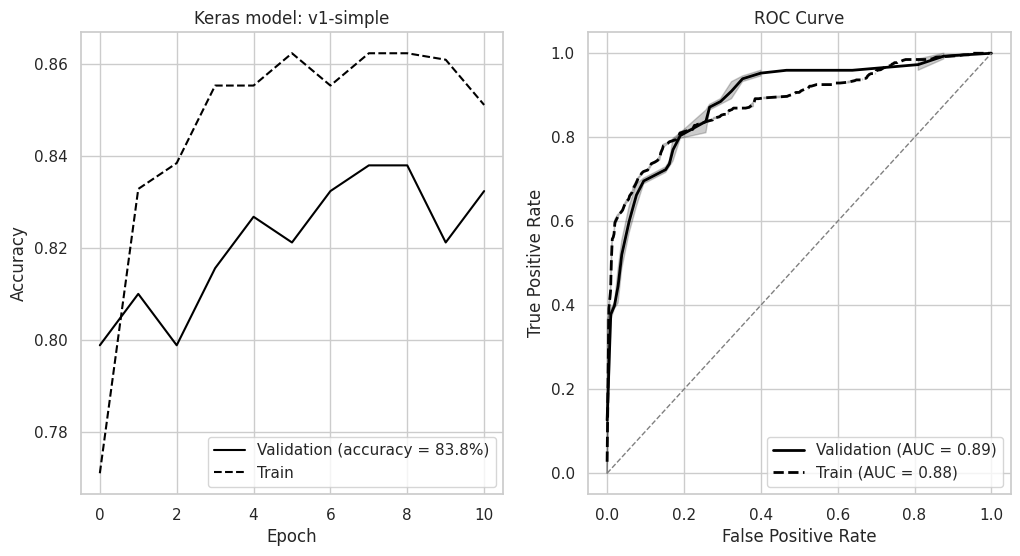

,Model,Dense Layers,Nodes,Dropout,LR,Accuracy,Train AUC,Val AUC
0,v1-simple,1,128,0,0.001,83.798885,0.881269,0.888288


In [231]:
# Set the model version
model_ver = 'v1-simple'

# Select callbacks
callbacks = []
#callbacks.append(set_checkpoint())
callbacks.append(set_learning_rate_reduction())
callbacks.append(set_early_stoping(patience=10))

# Execute the training
history, model = execute_training(
  X_train,
  y_train,
  X_val,
  y_val,
  model_ver=model_ver,
  plot_title=f'Keras model: {model_ver}',
  dense_layers=1,
  num_nodes=128,
  dropout=0,
  batch_size = 64,
  epochs = 20,
  learning_rate = 0.001,
  callbacks = callbacks
)

display(nn_results)

Training the simple model multiple times shows that slightly different networks are created, giving slightly different accuracies against the validation data.

Training this simple model 20 times gave accuracy between 0.832 and 0.849 with mean = 0.840 and standard devition = 0.006.

In [1]:
# Standard
accs = []
for i in range(20):
  # Create a model
  model = make_deep_model(
    dense_layers=[128],
    dropouts=[0],
    learning_rate=0.001
  )
  # Fit the model
  history = model.fit(
      X_train,
      y_train,
      epochs=20,
      callbacks=callbacks,
      validation_data=(X_val, y_val),
      verbose=0
  )

  # Find accuracy and append to list
  acc = max(history.history['val_accuracy'])
  print(acc)
  accs.append(acc)
accs = pd.Series(accs)

NameError: ignored

In [ ]:
print(f'Max accuracy:\t{accs.max():.3f}')
print(f'Min accuracy:\t{accs.min():.3f}')
print(f'Mean accuracy:\t{accs.mean():.3f}')
print(f'Standard Dev:\t{accs.std():.3f}')

### V2 - Number of Nodes

Changing the number of nodes in the single layer does not make a dramatic improvement on the accuracy, although a larger number of nodes does seem to be marginally more accurate.

In [ ]:
# Set the model version
model_ver = 'v2-nodes'

# Select callbacks
callbacks = []
#callbacks.append(set_checkpoint())
callbacks.append(set_learning_rate_reduction())
callbacks.append(set_early_stoping(patience=10))

for nodes in [64, 128, 256, 512]:
  # Execute the training
  history, model = execute_training(
    X_train,
    y_train,
    X_val,
    y_val,
    model_ver=model_ver,
    plot_title=f'Keras model: {model_ver} ({nodes} nodes per dense layer)',
    dense_layers=1,
    num_nodes=nodes,
    dropouts=0,
    batch_size = 64,
    epochs = 20,
    learning_rate = 0.001,
    callbacks = callbacks
  )

In [ ]:
nn_results

### V3 - Multiple Dense Layers


In [ ]:
# Set the model version
model_ver = 'v3-layers'

# Select callbacks
callbacks = []
#callbacks.append(set_checkpoint())
callbacks.append(set_learning_rate_reduction())
callbacks.append(set_early_stoping(patience=10))

for layers in [1 ,2, 3, 4, 5]:
  # Execute the training
  history, model = execute_training(
    X_train,
    y_train,
    X_val,
    y_val,
    model_ver=model_ver,
    plot_title=f'Keras model: {model_ver} ({layers} dense layers)',
    dense_layers=layers,
    num_nodes=64,
    dropout=0,
    batch_size = 64,
    epochs = 20,
    learning_rate = 0.001,
    callbacks = callbacks
  )

In [ ]:
nn_results

Additional layers and nodes bring a marginal benefit in accuracy.

### V4 - Dropout and Learning Rate



In [ ]:
# Set the model version
model_ver = 'v4-do/lr'

# Select callbacks
callbacks = []
#callbacks.append(set_checkpoint())
callbacks.append(set_learning_rate_reduction())
callbacks.append(set_early_stoping(patience=10))

for do in [0.1, 0.2, 0.3, 0.5]:
  for lr in [0.01, 0.001]:
    # Execute the training
    history, model = execute_training(
      X_train,
      y_train,
      X_val,
      y_val,
      model_ver=model_ver,
      plot_title=f'Keras model: {model_ver} (dropout={do}, lr={lr})',
      dense_layers=3,
      num_nodes=512,
      dropout=do,
      batch_size = 64,
      epochs = 30,
      learning_rate = lr,
      callbacks = callbacks
    )

In [ ]:
nn_results

Learning rate of 0.001 seems to give better accuracy than 0.01, and the learning rate is often being reduced by the ReduceLROnPlateau callback to 0.0005.

A dropout of around 20% seems to improve accuracy.

In [ ]:
for layers in [[128,512], [256,512], [512,512]]:
  print(layers)

In [ ]:
# Set the model version
model_ver = 'v5'

# Select callbacks
callbacks = []
#callbacks.append(set_checkpoint())
callbacks.append(set_learning_rate_reduction())
callbacks.append(set_early_stoping(patience=15))

for layers in [[128,512], [256,512], [512,512]]:
    # Execute the training
    history, model = execute_training(
      X_train,
      y_train,
      X_val,
      y_val,
      model_ver=model_ver,
      plot_title=f'Keras model: {model_ver} (layers={layers})',
      dense_layers=layers,
      dropouts=[0.2, 0.2],
      batch_size = 64,
      epochs = 40,
      learning_rate = 0.001,
      callbacks = callbacks
    )

In [ ]:
nn_results

A good set of values for 2 dense layers appears to be 256 nodes in the first and 512 nodes in the second, with dropout rates of 20% and learning rate of 0.001. Compare to three layers.

In [ ]:
for layers in [[256,512,512], [256,256,512]]:
    # Execute the training
    history, model = execute_training(
      X_train,
      y_train,
      X_val,
      y_val,
      model_ver=model_ver,
      plot_title=f'Keras model: {model_ver} (layers={layers})',
      dense_layers=layers,
      dropouts=[0.2, 0.2, 0.2],
      batch_size = 64,
      epochs = 40,
      learning_rate = 0.001,
      callbacks = callbacks
    )

In [ ]:
nn_results

The v5 model with 256, 512 and 512 nodes in three dense layers predicted the validation labels with high accuracy.

Re-train this model 20 times to see the variation in the accuracy given.

In [ ]:
finalnn_results = pd.DataFrame(columns=['Accuracy', 'Val AUC', 'Train AUC'])

# Enable checkpoint callback
callbacks = []
callbacks.append(set_checkpoint())
callbacks.append(set_learning_rate_reduction())
callbacks.append(set_early_stoping(patience=15))

for i in range(20):
  # Create a model
  model = make_deep_model(
    dense_layers=[256, 512, 512],
    dropouts=[0.2, 0.2, 0.2],
    learning_rate=0.001
  )
  # Fit the model
  history = model.fit(
      X_train,
      y_train,
      epochs=30,
      callbacks=callbacks,
      validation_data=(X_val, y_val),
      verbose=0
  )

  # Calculate True/False Positive Rates
  fpr_train, tpr_train, _ = roc_curve(y_train, model.predict(X_train).ravel())
  fpr_val, tpr_val, _ = roc_curve(y_val, model.predict(X_val).ravel())

  # Calculate accuracy and AUCs
  accuracy_val = max(history.history['val_accuracy'])*100
  auc_train = auc(fpr_train, tpr_train)
  auc_val = auc(fpr_val, tpr_val)

  # Add results to summary table
  results = [accuracy_val, auc_train, auc_val]
  finalnn_results.loc[len(finalnn_results)] = results

display(finalnn_results.head())

In [ ]:
finalnn_results.describe()

The mean accuracy for this neural network is 84.5(5)%. The mean training AUC is 0.89 and validation AUC is 0.90, suggesting the model is not overfitting.

This result is comparable with the K Nearest Neighbours model.